<h1> Import Modules, Databases, Credentials </h1>

In [1]:
from jdna import database
from jdna import Reaction, Convert, Sequence
import webbrowser
import re
import pandas as pd
import os
from copy import copy
import primer3
import math

#database.credentials['db_location'] = '/Users/klavinslab/Google Drive/Klavinslab/DNAdb'
database.credentials['db_location'] = '/Volumes/120GB SSD/Google Drive/Klavinslab/DNAdb'

#import_loc = '/Users/Justin/Desktop'
import_loc = '/Users/klavinslab/Desktop'
#gdrive_loc = '/Volumes/120GB SSD/Google Drive/Klavinslab'
gdrive_loc = '/Users/klavinslab/Google Drive/Klavinslab'
plan_loc = os.path.join(gdrive_loc, 'Projects/MammalianCellEngineering/Plans')
database.credentials['db_location'] = os.path.join(gdrive_loc, 'DNAdb')

<h2> Example PCR Reaction </h2>

In [2]:
template = database.db()['9320'] # grab sequence related to Aquarium sample id 9320
template = Convert.from_benchling(template)
p1 = database.get_jdna_primer('P1G1-kozak-mTUR2__fwd') # grab primer by name from database
p2 = database.get_jdna_primer('mTUR2-GSGLink1_rev')

product = Reaction.pcr(template, p1, p2)[0] # run pcr reaction, grab first product

<h1> Uploading and running plans </h1>

This is draft code for grabbing a cloning plan from an excel sheet
and running the cloning procedure *in silico*

In [6]:
plan_location = os.path.join(plan_loc, 'pINS-0A1-CMV-FLP.xlsx')
temp_database = {}

def import_plan(plan_location):
    def clean_excel_data(data):
        for row in data:
            while '' in row:
                row.remove('')

    def parse_sheet(df):
        rows = []
        for row in df.set_index(df.columns[0]).iterrows():
            rows.append([row[0]] + list(row[1].dropna()))
        clean_excel_data(rows)
        return rows
    
    def parse_plasmid_sheet(df):
        plasmid_rows = []
        for row in df.iterrows():
            plasmid_info = dict(row[1])
            name = plasmid_info['Plasmid']
            bact_marker = plasmid_info['BacterialMarker']
            yeast_marker = plasmid_info['YeastMarker']
            if math.isnan(yeast_marker):
                yeast_marker = 'NA'
            seq_primers = str(plasmid_info['SequencingPrimers'])
            if not seq_primers == '':
                seq_primers = [int(x.strip()) for x in seq_primers.split(',')]
            else:
                seq_primers = []

            fragments = []
            for key in plasmid_info:
                if key.startswith('Fragment') or key.startswith('Unnamed'):
                    f_label = plasmid_info[key]
                    if isinstance(f_label, float):
                        if math.isnan(f_label):
                            continue
                    elif isinstance(f_label, basestring):
                        f_label = str(f_label).strip()
                    if f_label == '':
                        continue
                    fragments.append(f_label)
            plasmid_rows.append(dict(
                    name=name, 
                    bact_marker=bact_marker, 
                    yeast_marker=yeast_marker, 
                    seq_primers=seq_primers, 
                    fragments=fragments))
        return plasmid_rows

    x1 = pd.ExcelFile(plan_location)
    primer_rows = parse_sheet(x1.parse("Primers"))
    fragment_rows = parse_sheet(x1.parse("Fragments"))
    plasmid_rows = parse_plasmid_sheet(x1.parse("Plasmids"))

    return primer_rows, fragment_rows, plasmid_rows

def find_location_of(item_name):
    db = database.db()
    in_db = item_name in db
    db.close()
    
    in_aq = False
    try: 
        database.get_sample(item_name)
        in_aq = True
    except: in_aq = False
    in_temp = item_name in temp_database
    return {'db': in_db, 'aq': in_aq, 'temp': in_temp}

def get_from_anywhere(item_name):
    if isinstance(item_name, int):
        item_name = database.get_sample(item_name)['name']
    location = find_location_of(item_name)
    if location['db']:
        try:
            return database.get_jdna(item_name)
        except Exception as e:
            print e
            return database.get_jdna_primer(item_name)
    else:
        if location['aq']:
            s = database.get_sample(item_name)
            sample_type = s['sample_type_id']
            if sample_type == 1:
                database.update_primer(item_name)
                return database.get_jdna_primer(item_name)
            elif sample_type == 2:
                database.update_sequence(item_name)
                return database.get_jdna(item_name)
            elif sample_type == 4:
                database.update_fragment_sequence(item_name)
                return database.get_jdna(item_name)
        elif location['temp']:
            return temp_database[item_name]
        else:
            raise Exception('Could not find {} anywhere'.format(item_name))
            

def collect_primer_plans(primer_rows):
    print
    print "#"*50
    print "PRIMERS"
    print "#"*50
    print
    def parse_primer_info(primer_info):

        def parse_primer_name(primer_name):
            parsed = re.search('(.+)_(f|r|rev|fwd)$', primer_name, re.IGNORECASE)
            return parsed.groups()

        def determine_direction(primer_suffix):
            direction = None
            if suffix.startswith('f') or suffix.startswith('F'):
                direction = 1
            elif suffix.startswith('r') or suffix.startswith('R'):
                direction = -1
            return direction

        def combine(*parts):
            for p in parts:
                p.create_feature(p.name, 'misc', 0, len(p) - 1)
            last = None
            for p in parts:
                if last is None:
                    last = p
                    continue
                last = last + p
            return last

        name = primer_info[0]
        seqs = primer_info[1:] 
        prefix, suffix = parse_primer_name(name)
        direction = determine_direction(suffix)
        feature_names = prefix.split('-')

        if not len(seqs) == len(feature_names):
            raise Exception("primer misformatted {}".format(primer_info))

        # zip feature name and sequences
        features = zip(feature_names, seqs)
        features = [list(x) for x in features]

        # make jdna from features
        for f in features:
            f[1] = Sequence(sequence=f[1])
            f[1].create_feature(f[0], 'misc', 0, len(f[1])-1)

        if direction == -1:
            features = features[::-1]
            for f in features:
                f[1].reverse_complement()

        anneal, overhang = None, None

        o_seqs = [x[1] for x in features[:-1]]
        primer_seq = None
        anneal_seq = features[-1][1]
        overhang_seq = None
        if o_seqs == []:
            primer_seq = anneal_seq
            overhang_seq = ''
        else:
            overhang_seq = combine(*o_seqs)
            primer_seq = overhang_seq + anneal_seq

        # parse features into string description
        description = ''
        s = []
        for f in features:
            seq = copy(f[1])
            if direction == -1:
                seq.reverse_complement()
            s.append('{}: {} | '.format(f[0], str(seq)))
        if direction == -1:
            s = s[::-1]
        description = ''.join(s)

        # annotate the jdna fields
        primer_seq.name = name
        primer_seq.tm = Reaction.tm(anneal_seq)            
        primer_seq.overhang = str(overhang_seq)
        primer_seq.anneal = str(anneal_seq)
        primer_seq.description = description
        primer_seq.project = 'ProgrammedDifferentiation'

        # assert everything is OK
        expected = Sequence(sequence=''.join(seqs))
        if direction == -1:
            expected.reverse_complement()
        assert(str(primer_seq) == str(expected))

        return primer_seq
    
    primers = []
    for primer_info in primer_rows:
        primer = parse_primer_info(primer_info)
        temp_database[primer.name] = primer
        primers.append(primer)
    for i, p in enumerate(primers):
        print '\t({})\t{}\t{}'.format(i, p.name, p)
        print '\t\tHairpin >',primer3.calcHairpin(str(p).upper())
        print '\t\tHomodimer >',primer3.calcHomodimer(str(p).upper())
    return primers
    

def collect_fragment_plans(fragment_rows):
    print
    print "#"*50
    print "FRAGMENTS"
    print "#"*50
    print
    
    def _run_fragment_plan(fragment_name, depth):
        # return if it is already in temp
        if temp_database[fragment_name] is not None:
            return temp_database[fragment_name]

        
                           
        plan = fragment_plans[fragment_name]
        p1, p2, template = [get_from_anywhere(x) for x in plan[1:]]
        print '\n' + '*'*35
        print '>> simulating fragment construction'
        print '  Name: {}'.format(fragment_name)
        print '\tprimer 1: {} {}'.format(p1.name, p1)
        print '\tprimer 2: {} {}'.format(p2.name, p2)
        print '\ttemplate: {}'.format(template.name)

        # recursive if template is None (meaning its another fragment)
        if template is None:
            template = _run_fragment_plan(plan[3], depth+1)
            temp_database[plan[3]] = template
        
        # write annealing report
        print '\n\n\tAnnealing:'

        ann1 = Reaction.anneal_primer(template, p1)
        ann2 = Reaction.anneal_primer(template, p2)
        F = ann1['F'] + ann2['F']
        R = ann1['R'] + ann2['R']
        print '\t\t   name\ttm\tpos\tlen'
        for f in F:
            print '\t\tF: {}\t{:.2f} C\t{}\t{}'.format(f['primer'].name, f['tm'], f['pos'], f['len'])
        for r in R:
            print '\t\tR: {}\t{:.2f} C\t{}\t{}'.format(r['primer'].name, r['tm'], r['pos'], r['len'])
        annealing_report = 'Tm_F: {} Tm_R: {}'.format(int(F[0]['tm']), int(R[0]['tm']))

        # secondary structure report
        print '\t\tHeterodimer >',primer3.calcHeterodimer(str(p1).upper(), str(p2).upper())
        
        # do pcr
        print '\n\tProducts:'
        products = Reaction.pcr(template, p1, p2)

        if len(products) > 1:
            raise Exception('more than one product')
        product = products[0]
        print '\t\tLength: {}'.format(len(product))
        temp_database[plan[0]] = product

        product.name = fragment_name
        product.description = annealing_report
        product.forward_primer = F[0]['primer'].name
        product.reverse_primer = R[0]['primer'].name
        product.template = template.name
        product.depth = depth
        return product
    
    # initialize fragments in the temp_database      
    fragment_plans = {}
    for i, row in enumerate(fragment_rows):
        temp_database[row[0]] = None
        fragment_plans[row[0]] = row
        print '\t({})  {}'.format(i, row[0])
        for x in zip(['p1', 'p2', 'template'], row[1:]):
            print '\t\t{}: {}'.format(x[0], x[1])
    fragments = []
    for row in fragment_rows:
        fragment_name = row[0]
        fragments.append(_run_fragment_plan(fragment_name, 0))
    return fragments
        

def collect_plasmid_plans(plasmid_rows):
    print
    print "#"*50
    print "PLASMIDS"
    print "#"*50
    print
    for i, plasmid_info in enumerate(plasmid_rows):
        print '\t({}) {}:'.format(i, plasmid_info['name'])
        print '\t\tBacterial Marker: {}'.format(plasmid_info['bact_marker'])
        print '\t\tYeast Marker: {}'.format(plasmid_info['yeast_marker'])
        print '\t\tSequencing Primers: {}'.format(plasmid_info['seq_primers'])
        print
        for f in plasmid_info['fragments']:
            print '\t\t{}'.format(f)
    plasmids = []
    for plasmid_info in plasmid_rows:
        plasmid_name = plasmid_info['name']
        bact_marker = plasmid_info['bact_marker']
        yeast_marker = plasmid_info['yeast_marker']
        seq_primers = plasmid_info['seq_primers']
        print '\tFinding Fragments'
        for i, info in enumerate(plasmid_info['fragments']):
            s = None
            try:
                s = database.aqapi.find('sample', {'name': info})['rows'][0]['id']
            except:
                pass
            print '\t\t({}) {} {}'.format(i, info, s)
        fragments = [get_from_anywhere(x) for x in plasmid_info['fragments']]
        try:
            print '\tName: {}'.format(plasmid_name)
            print '\t\tRunning assembly...'
            products = Reaction.cyclic_assembly(fragments)
            if len(products) > 1:
                raise Exception("Gibson yeilded more than one product")
            product = products[0]
            product.description = ''
            product.name = plasmid_name
            product.fragments = plasmid_info['fragments']
            product.yeast_marker = yeast_marker
            product.bact_marker = bact_marker
            product.seq_primers = seq_primers
            plasmids.append(product)
            print '\tSuccess:'
            print '\t\tLength: {}'.format(len(product))
        except Exception as e:
            print "Gibson", plasmid_name, "failed"
            print e
    return plasmids
        
# throw error if annealing sequence is less than 18
# throw error if annealing temperature is too low
# fix annealing temperature calculation (there is a minus 3, there shouldn't be'), the Tas are way too low
# throw error if total length is greater than 60
# start using nicks primer design stuff...
# round to int for uploading Tms of primers
# stop saving Tms to description

print 'Plan location: {}'.format(plan_location)
# raw_input("Continue with plan?")
primer_rows, fragment_rows, plasmid_rows = import_plan(plan_location)
# print plasmid_rows
primers = collect_primer_plans(primer_rows)
fragments = collect_fragment_plans(fragment_rows)
plasmids = collect_plasmid_plans(plasmid_rows)


# commit plans to database
# save import sheets
# upload to aquarium
# update name of sequence
# raw_input("Upload samples to Aquarium from {}".format(import_loc))
# print 'Updating internal database at {}'.format(database.credentials['db_location'])

Plan location: /Users/klavinslab/Google Drive/Klavinslab/Projects/MammalianCellEngineering/Plans/pINS-0A1-CMV-FLP.xlsx

##################################################
PRIMERS
##################################################

	(0)	UTP1-CMV_early_enhancer_fwd	GCCGATACGAAGGTTTTCTCCAGCGgatgtacgggccagatatacgcgtt
		Hairpin > ThermoResult(structure_found=True, tm=34.94, dg=505.85, dh=-75500.00, ds=-245.06)
		Homodimer > ThermoResult(structure_found=True, tm=22.39, dg=-5014.97, dh=-125400.00, ds=-388.15)

##################################################
FRAGMENTS
##################################################

	(0)  UTP1-CMV_enhancer-CMV-FLP-TP
		p1: UTP1-CMV_early_enhancer_fwd
		p2: _FLP-TP_rev
		template: pog44
	(1)  UTP1-CMV_enhancer-CMV-FLP-SV40NLS2
		p1: UTP1-CMV_early_enhancer_fwd
		p2: _FLP-SV40NLS2_rev
		template: pog44
	(2)  UTP1-CMV_enhancer-CMV-FLP-SV40NLS2-T2A
		p1: UTP1-CMV_early_enhancer_fwd
		p2: SV40NLS2-T2A__rev
		template: UTP1-CMV_enhancer-CMV-FLP-SV40NLS2


/Users/klavinslab/anaconda/envs/python2/lib/python2.7/site-packages/bs4/__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


'bases'
'bases'

***********************************
>> simulating fragment construction
  Name: UTP1-CMV_enhancer-CMV-FLP-TP
	primer 1: Primer 16614_UTP1-CMV_early_enhancer_fwd gccgatacgaaggttttctccagcggatgtacgggccagatatacgcgtt
	primer 2: Primer 16530__FLP-TP_rev tgactcgaggtcgacggtatcattatatgcgtctatttatgtaggatgaaagg
	template: pog44


	Annealing:
		   name	tm	pos	len
		F: Primer 16614_UTP1-CMV_early_enhancer_fwd	59.32 C	236	25
		R: Primer 16530__FLP-TP_rev	56.44 C	3343	31
		Heterodimer > ThermoResult(structure_found=True, tm=-8.93, dg=-4731.24, dh=-37300.00, ds=-105.01)

	Products:
		Length: 2105
'bases'
'bases'

***********************************
>> simulating fragment construction
  Name: UTP1-CMV_enhancer-CMV-FLP-SV40NLS2
	primer 1: Primer 16614_UTP1-CMV_early_enhancer_fwd gccgatacgaaggttttctccagcggatgtacgggccagatatacgcgtt
	primer 2: Primer 16533__FLP-SV40NLS2_rev aactttcctcttcttcttgggtatgcgtctatttatgtaggatgaaagg
	template: pog44


	Annealing:
		   name	tm	pos	len
		F: Primer 1661

KeyError: 'Anneal Sequence'

<h3> Running a gibson workflow from a task id </h3>

In [5]:
database.gibson_workflow(31087)

Gibson Assembly: 31087 16436: pINS-0A1-pEF1a-kozak-AFB2-GSG-T2A-Citrine-IAA17
Plasmid: 16436 pINS-0A1-pEF1a-kozak-AFB2-GSG-T2A-Citrine-IAA17
Fragments: [15898, 15899, 16430, 16438]
OUT > Item 16436 pINS-0A1-pEF1a-kozak-AFB2-GSG-T2A-Citrine-IAA17 registered.
create_sequence started
Overwrite on: deleting seq seq_sfiAxw84
delete_sequence started
delete_sequence ended
create_sequence ended
www.benchling.com/jvrana/f/gCtuy36n-jdna/seq-t8rBBAFn-pins-0a1-pef1a-kozak-afb2-gsg-t2a-citrine-iaa17/edit


<h2> Plans >>> Import CSV for Aquarium </h2>

In [10]:
def map_keys_to(old_dict, new_dict, old_keys, new_keys):
    for k, m in zip(old_keys, new_keys):
        new_dict[m] = old_dict[k]
    return new_dict

def fragments_to_pandas(fragments):
    old_keys = ['name', 'forward_primer', 'reverse_primer', 'template', 'description']
    new_keys = ['Fragment', 'Forward Primer', 'Reverse Primer', 'Template', 'Description']

    rows = []
    for f in fragments:
        info = map_keys_to(f.__dict__, {}, old_keys, new_keys)
        info['Length'] = len(f)
        rows.append(info)
    df = pd.DataFrame(rows)
    df = df[new_keys + ['Length']]
    df['Project'] = 'ProgrammedDifferentiation'
    df = df.set_index('Fragment')
    from IPython import display
    display.display(df)
    return df

def primers_to_pandas(primers):
    old_keys = ['name', 'overhang', 'anneal', 'tm', 'description']
    new_keys = ['Primer', 'Overhang Sequence', 'Anneal Sequence', 'T Anneal', 'Description']
    
    rows = []
    for p in primers:
        rows.append(map_keys_to(p.__dict__, {}, old_keys, new_keys))
    df = pd.DataFrame(rows)
    df = df[new_keys]
    df['Project'] = 'ProgrammedDifferentiation'
    df = df.set_index('Primer')
    from IPython import display
    display.display(df)
    return df

def plasmids_to_pandas(plasmids):
    old_keys = ['name', 'description', 'yeast_marker', 'bact_marker']
    new_keys = ['Plasmid', 'Description', 'Yeast Marker', 'Bacterial Marker']
    columns = new_keys
    rows = []
    mx = 0
    for p in plasmids:
        if len(p.seq_primers) > mx:
            mx = len(p.seq_primers)
     
    for p in plasmids:
        info = map_keys_to(p.__dict__, {}, old_keys, new_keys)
        info['Length'] = len(p)
        seq = ['']*mx
        for i, primer in enumerate(p.seq_primers):
            seq[i] = primer
        for i, s in enumerate(seq):
            col = 'Sequencing Primers__{}'.format(i)
            info[col] = s
            
        # get benchling url
        bseq = Convert.to_benchling_json(p)
        bseq['folder'] = database.api.find_folder('jdna', regex=True)['id']
        bseq['overwrite'] = True
        seq = database.api.create_sequence(**bseq)
        p.sequence_url = 'www.benchling.com' + seq['editURL']
        info['Sequence'] = p.sequence_url
        
        rows.append(info)
    df = pd.DataFrame(rows)
    
    for i in range(mx):
        columns.append('Sequencing Primers__{}'.format(i))
    columns.append('Sequence')
    df = df[columns]
    df['Project'] = 'ProgrammedDifferentiation'
    df = df.set_index('Plasmid')
    from IPython import display
    display.display(df)
    
    return df

def fragments_to_import_csv(fragments, destination=os.path.join(import_loc, 'fragments_import.csv')):
    df = fragments_to_pandas(fragments).to_csv(destination)

def primers_to_import_csv(fragments, destination=os.path.join(import_loc, 'primers_import.csv')):
    df = primers_to_pandas(fragments).to_csv(destination)
    
def plasmids_to_import_csv(plasmids, destination=os.path.join(import_loc, 'plasmids_import.csv')):
    df = plasmids_to_pandas(plasmids).to_csv(destination)
    s = None
    with open(destination, 'r') as f:
        s = f.read()
        s = re.sub('Sequencing Primers__\d+', 'Sequencing Primers', s)
    with open(destination, 'wb') as f:
        f.write(s)
    return s

primers_to_import_csv(primers)
fragments_to_import_csv(fragments)
plasmids_to_import_csv(plasmids)

raw_input('upload spread sheets.')
raw_input('commit to db')

for p in primers:
    database.update_primer(p.name)
for f in fragments:
    database.update_fragment_sequence(f.name)
for p in plasmids:
    database.update_sequence(p.name)
for p in plasmids:
    s = database.get_sample(p.name)
    print '{}_{}'.format(s['id'], s['name'])
    for f in p.fragments:
        fs = database.get_sample(f)
        print 'Fragment', fs['id'], fs['name']
raw_input('submit gibson tasks')


,Overhang Sequence,Anneal Sequence,T Anneal,Description,Project
Primer,,,,,
UTP1-CMV_early_enhancer_fwd,GCCGATACGAAGGTTTTCTCCAGCG,gatgtacgggccagatatacgcgtt,59.324,UTP1: GCCGATACGAAGGTTTTCTCCAGCG | CMV_early_en...,ProgrammedDifferentiation


,Forward Primer,Reverse Primer,Template,Description,Length,Project
Fragment,,,,,,
UTP1-CMV_enhancer-CMV-FLP-TP,UTP1-CMV_early_enhancer_fwd,Primer 16530__FLP-TP_rev,pog44,Tm_F: 59 Tm_R: 56,2105,ProgrammedDifferentiation
UTP1-CMV_enhancer-CMV-FLP-SV40NLS2,UTP1-CMV_early_enhancer_fwd,Primer 16533__FLP-SV40NLS2_rev,pog44,Tm_F: 59 Tm_R: 55,2101,ProgrammedDifferentiation
UTP1-CMV_enhancer-CMV-FLP-SV40NLS2-T2A,UTP1-CMV_early_enhancer_fwd,Primer 16534_SV40NLS2-T2A__rev,UTP1-CMV_enhancer-CMV-FLP-SV40NLS2,Tm_F: 73 Tm_R: 50,2140,ProgrammedDifferentiation


create_sequence started
create_sequence ended
create_sequence started
create_sequence ended


,Description,Yeast Marker,Bacterial Marker,Sequencing Primers__0,Sequencing Primers__1,Sequence,Project
Plasmid,,,,,,,
pINS-0A1-CMV-FLP,,NA,Amp,1555,1556,www.benchling.com/jvrana/f/gCtuy36n-jdna/seq-6...,ProgrammedDifferentiation
pINS-0A1-CMV-FLP-SV40-T2A-Citrine,,NA,Amp,1555,1556,www.benchling.com/jvrana/f/gCtuy36n-jdna/seq-J...,ProgrammedDifferentiation


upload spread sheets.


KeyboardInterrupt: 

<h1> OLD CODE </h1>

In [ ]:
database

In [18]:
for p in primers:
    database.update_primer(p.name)
for f in fragments:
    database.update_fragment_sequence(f.name)
for p in plasmids:
    database.update_sequence(p.name)
for p in plasmids:
    s = database.get_sample(p.name)
    print '{}_{}'.format(s['id'], s['name'])
    for f in p.fragments:
        fs = database.get_sample(f)
        print 'Fragment', fs['id'], fs['name']
raw_input('submit gibson tasks')

Item 16568 P1G1-kozak-mTUR2__fwd registered.
could not parse primer features
Item 16569 mTUR2-GSGLink1_rev registered.
getting sequence for pLSL-[ADH1]-p35S:mTURQ:t35S-[ADH1]-R


IndexError: list index out of range

In [38]:
primers = database.aqapi.find('sample', {'user_id': 66, 'sample_type_id': 1})['rows']
primer_tuple = [(p['id'], p['name']) for p in primers]
primer_tuple.sort(reverse=True)
for p in primer_tuple[:30]:
    database.update_primer(p[1])

Item 16614 UTP1-CMV_early_enhancer_fwd registered.
could not parse primer features
Item 16569 mTUR2-GSGLink1_rev registered.
Item 16568 P1G1-kozak-mTUR2__fwd registered.
could not parse primer features
Item 16536 _Citrine-stop-TP_rev registered.
Item 16535 _T2A-Citrine__fwd registered.
could not parse primer features
Item 16534 SV40NLS2-T2A__rev registered.
could not parse primer features
Item 16533 _FLP-SV40NLS2_rev registered.
Item 16532 P1G1-kozak-ATG-SV40NLS1_fwd registered.
Item 16531 SV40NLS1-FLP__fwd registered.
could not parse primer features
Item 16530 _FLP-TP_rev registered.
Item 16529 P1G1-kozak-FLP__fwd registered.
Item 16448 DTBA-CRPos1-TP_fwd registered.
Item 16447 _GSGLink2-CRPos0-DTBA_rev registered.
Item 16446 HDAC4-CRPos1-TP_rev registered.
Item 16445 CRPos0-HDAC4_fwd registered.
Item 16444 _HDAC4_elimBsaI_beginning__fwd registered.
Item 16443 _HDAC4_elimBsaI_middle__rev registered.
Item 16442 _HDAC4_elimBsaI_middle__fwd registered.
Item 16441 _HDAC4_elimBsaI_end_rev 

0
primer    0          P1G1-kozak-FLP__fwd
          1                  _FLP-TP_rev
          2            SV40NLS1-FLP__fwd
          3  P1G1-kozak-ATG-SV40NLS1_fwd
          4            _FLP-SV40NLS2_rev
          5            SV40NLS2-T2A__rev
          6            _T2A-Citrine__fwd
          7         _Citrine-stop-TP_rev
hairpinr  0                     -242.889
          1                     -592.322
          2                      960.126
          3                     -242.889
          4                      1859.25
          5                     -238.579
          6                     -2941.58
          7                     -592.322
homodimer 0                     -3745.54
          1                     -6535.02
          2                     -3745.54
          3                     -2994.79
          4                     -3097.43
          5                     -6204.57
          6                     -10911.2
          7                     -6535.02

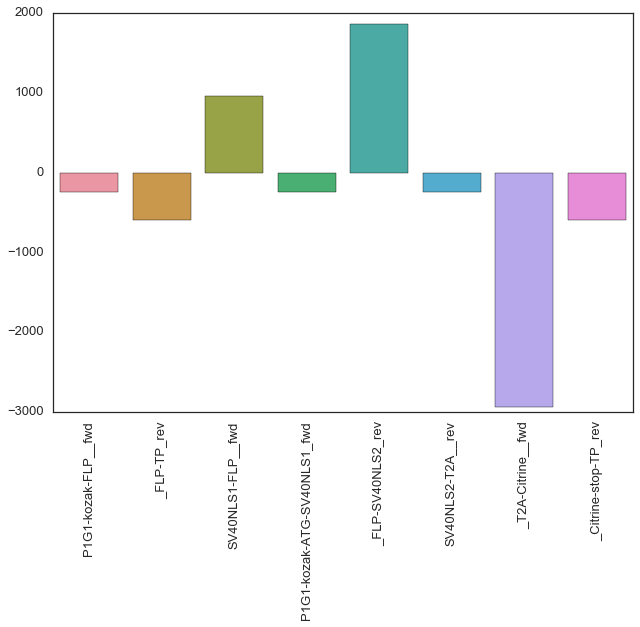

In [364]:
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", context="talk")


x = [p.name for p in primers]
y = [primer3.calcHairpin(str(p).upper()).dg for p in primers]

g = sns.barplot(x, y)
g.set_xticklabels(x, rotation=90)

y2 = [primer3.calcHomodimer(str(p).upper()).dg for p in primers]
df = pd.DataFrame()
df['primer'] = x
df['hairpinr'] = y
df['homodimer'] = y2
pd.DataFrame(df.unstack())

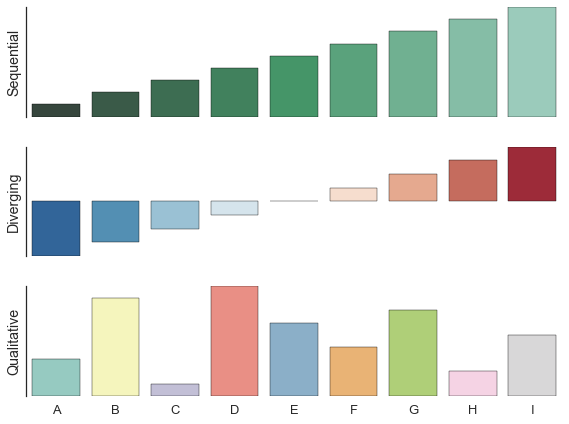

In [329]:
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", context="talk")
rs = np.random.RandomState(7)


# Set up the matplotlib figure
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

# Generate some sequential data
x = np.array(list("ABCDEFGHI"))
y1 = np.arange(1, 10)
sns.barplot(x, y1, palette="BuGn_d", ax=ax1)
ax1.set_ylabel("Sequential")

# Center the data to make it diverging
y2 = y1 - 5
sns.barplot(x, y2, palette="RdBu_r", ax=ax2)
ax2.set_ylabel("Diverging")

# Randomly reorder the data to make it qualitative
y3 = rs.choice(y1, 9, replace=False)
sns.barplot(x, y3, palette="Set3", ax=ax3)
ax3.set_ylabel("Qualitative")

# Finalize the plot
sns.despine(bottom=True)
plt.setp(f.axes, yticks=[])
plt.tight_layout(h_pad=3)

In [30]:
j = get_from_anywhere(16530)
print j.__dict__

database.get_jdna_primer(16614).__dict__

'bases'
could not parse primer features
{'description': u'_FLP: cctttcatcctacataaatagacgcatataa | TP: TGATACCGTCGACCTCGAGTCA | ', 'name': 'Primer 16530__FLP-TP_rev', 'first': t}
Item 16614 UTP1-CMV_early_enhancer_fwd registered.


{'description': u'UTP1: GCCGATACGAAGGTTTTCTCCAGCG | CMV_early_enhancer: gatgtacgggccagatatacgcgtt | ',
 'first': g,
 'name': 'Primer 16614_UTP1-CMV_early_enhancer_fwd'}

In [112]:
from jdna import database
from jdna import Reaction, Convert, Sequence
import webbrowser
import re
import pandas as pd
#database.credentials['db_location'] = '/Users/klavinslab/Google Drive/Klavinslab/DNAdb'
database.credentials['db_location'] = '/Volumes/120GB SSD/Google Drive/Klavinslab/DNAdb'

temp_database = {}

def capture(primer, type='primer'):
    try:
        return database.get_jdna(primer)
    except:
        pass
    try:
        return database.get_jdna_primer(primer)
    except:
        pass
    def get_name(name):
        if isinstance(name, int):
            name = database.aqapi.find('sample', {'id': name})['rows'][0]['name']
        return name
    name = get_name(primer)
    if name in temp_database:
        return temp_database[name]
    else:
        if type == 'primer':
            return database.get_jdna_primer(name)
        elif type == 'dna':
            return database.get_jdna(name)

def temp_fragment(template_name, p1_name, p2_name):
    template = capture(template_name, type='dna')
    p1 = capture(p1_name, type='primer')
    p2 = capture(p2_name, type='primer')
    print Reaction.anneal_primer(template, p1)
    print Reaction.anneal_primer(template, p2)
    print template.is_cyclic()
    products = Reaction.pcr(template, p1, p2)
    print '{} products'.format(len(products))
    if len(products) > 1:
        raise Exception('more than one product')
    #temp_seq(products[0])
    print len(products[0])
    return products[0]

def temp_seq(jdna_product):
    bseq = Convert.to_benchling_json(jdna_product)
    bseq['name'] = 'temporary sequence'
    bseq['folder'] = database.api.find_folder('jdna', regex=True)['id']
    bseq['overwrite'] = True
    seq = database.api.create_sequence(**bseq)
    url = 'https://' + 'www.benchling.com' + seq['editURL']
    webbrowser.open(url)
    

primers = database.aqapi.find('sample', {'sample_type_id': 1})['rows']

for p in primers:
    m = re.search('link.+mxi', p['name'])
    if m is not None:
        print p['id'], p['name']

1371 linkseq-mxi1-front
1372 linkseq-mxi1-back-TP
5376 linker-mxi1_f
14308 linker-RNAbinder-mxi1-r


In [ ]:
import csv
import re
from IPython import display

temp_database = {}

# Combine primer parts with features
def combine(*parts):
    for p in parts:
        p.create_feature(p.name, 'misc', 0, len(p) - 1)
    last = None
    for p in parts:
        if last is None:
            last = p
            continue
        last = last + p
    return last

def open_csv(location):
    with open(location) as f:
        spamreader = csv.reader(f, delimiter=',')
        return list(spamreader) 

# parse excel helper
def collect_primer_plans(rows):
    primers = [] # list of jdna_primers
    for row in rows:
        primer_name = row[0].strip()
        if primer_name == '':
            continue
        sequences = row[1:]
        while '' in sequences:
            sequences.remove('')
        parsed = re.search('(.+)_([FR(?:fwd)(?:rev)])', primer_name, re.IGNORECASE)
        suffix = parsed.group(2)
        prefix = parsed.group(1)

        # Get Direction
        direction = None
        if suffix.startswith('f') or suffix.startswith('F'):
            direction = 'fwd'
        elif suffix.startswith('r') or suffix.startswith('R'):
            direction = 'rev'

        # Assert matches between features and sequences
        assert(direction is not None)
        if not len(prefix.split('-')) == len(sequences):
            print row
            print prefix.split('-')
            print sequences
            print len(prefix.split('-')), len(sequences)
            raise Exception("primers misformatted")
        prefixes = prefix.split('-')

        features = zip(prefixes, sequences)
        anneal, overhang = None, None

        # Grab annealing sequences
        if direction == 'fwd':
            anneal = features[-1]
            overhang = features[:-1]
        if direction == 'rev':
            anneal = features[0]
            overhang = features[1:]
        
        # turn sequences into jdna
        anneal_seq = Sequence(sequence=anneal[1], name=anneal[0])
        overhang_seq = None
        primer_seq = None
        
        # get overhang sequence
        if overhang == []:
            overhang_seq = ''
            if direction == 'rev':
                anneal_seq.reverse_complement()
            primer_seq = anneal_seq
        else:
            o_seqs = []
            for o in overhang:
                o_seqs.append(Sequence(sequence=o[1], name=o[0]))
            overhang_seq = combine(*o_seqs)
            if direction == 'rev':
                anneal_seq.reverse_complement()
                overhang_seq.reverse_complement()
            primer_seq = overhang_seq + anneal_seq

        description = ''
        for f in features:
            seq = Sequence(sequence=f[1])
            if direction == 'rev':
                seq.reverse_complement()
            description += '{}: {} | '.format(f[0], str(seq))
                
        # annotate the jdna fields
        primer_seq.name = primer_name
        primer_seq.tm = Reaction.tm(anneal_seq)            
        primer_seq.overhang = str(overhang_seq)
        primer_seq.anneal = str(anneal_seq)
        primer_seq.description = description
        primer_seq.project = 'ProgrammedDifferentiation'
        #append
        temp_database[primer_seq.name] = primer_seq
        primers.append(primer_seq)
    return primers
        

def collect_fragment_plans(rows):
    seq_rows = []
    fragment_plans = {}
    print
    print
    print "collecting fragment plans"
    print
    for row in rows:
        note = ''
        name, fwd_name, rev_name, template_name = row
        try:
            fwd = capture(fwd_name, type='primer') 
        except:
            note += 'missing {}\n'.format(fwd_name)
            fwd = None
        try:
            rev = capture(rev_name, type='primer')
        except:
            note += 'missing {}\n'.format(rev_name)
            rev = None
        try:
            template = capture(template_name, type='dna')
        except:
            template = None
            
        #empty fragment
        fragment_plan = dict(
            fwd=fwd,
            rev=rev,
            template=template,
            fwd_name=fwd_name,
            rev_name=rev_name,
            template_name=template_name,
            sequence=None,
        )
        fragment_plans[name] = fragment_plan
    return fragment_plans

def collect_plasmid_plans(rows):
    plasmid_plans = {}
    for row in rows[1:]:
        name = row[0]
        fragment_labels = row[1:]
        fragments = []
        for f in fragment_labels:
            try:
                fragments.append(capture(f))
            except:
                try:
                    fragments.append(database.get_jdna(f))
                except:
                    try:
                        database.update_fragment_sequence(f)
                        fragments.append(capture(f))
                    except:
                        fragments.append(None)
        try:
            products = Reaction.cyclic_assembly(fragments)
            if len(products) > 1:
                print 'yeilded more than one product...'
            product = products[0]
            product.name = name
            plasmid_plans[name] = {'sequence': product, 'fragments': fragments}
        except Exception as e:
            print
            print e
            print '**** gibson assembly failed for', name
            print 
    return plasmid_plans

def collect_plans():
    
    def parse_sheet(df):
        rows = []
        for row in df.set_index(df.columns[0]).iterrows():
            rows.append([row[0]] + list(row[1].dropna()))
        return rows
    
    x1 = pd.ExcelFile('/Users/Justin/Desktop/TestSheet.xlsx')
    primer_rows = parse_sheet(x1.parse("Primers"))
    fragment_rows = parse_sheet(x1.parse("Fragments"))
    
    # Primer plans
    primer_plans = collect_primer_plans(primer_rows)
    import_primer = primer_plan_to_csv(primer_plans)
    display.display(import_primer)
    
    # Fragment plans
    fragment_plans = collect_fragment_plans(fragment_rows)
    run_fragment_plans(fragment_plans)
    import_fragment = fragment_plan_to_csv(fragment_plans)
    display.display(import_fragment)
        

def run_fragment_plans(fragment_plans):
    for f in fragment_plans:
        print 'running plans for fragment', f
        _run_fragment_plans(f, fragment_plans)
        
    rows = []
    for f in fragment_plans:
        plan = fragment_plans[f]
        seq = plan['sequence']
        if seq is None:
            continue
        row = [
            seq.name,
            'ProgrammedDifferentiation',
            plan['template'].name,
            plan['fwd'].name,
            plan['rev'].name,
            len(seq)
        ]
        rows.append(row)
    return pd.DataFrame(rows)

def _run_fragment_plans(fragment_name, fragment_plans):
    plan = fragment_plans[fragment_name]
    if plan['sequence'] is not None:
        return plan['sequence']
    if plan['template'] is None:
        try:
            plan['template'] = _run_fragment_plans(plan['template_name'], fragment_plans)
        except KeyError:
            print '*** could not process {} ***'.format(fragment_name)
            return None
    template, p1, p2 = plan['template'], plan['fwd'], plan['rev']
    ann1 = Reaction.anneal_primer(template, p1)
    ann2 = Reaction.anneal_primer(template, p2)
    f = ann1['F'] + ann2['F']
    r = ann1['R'] + ann2['R']
    print 'F', f
    print 'R', r
    annealing_report = 'Tm_F: {} Tm_R: {}'.format(int(f[0]['tm']), int(r[0]['tm']))
    products = Reaction.pcr(template, p1, p2)
    if len(products) > 1:
        raise Exception('more than one product')
    updated_fragment = products[0]
    updated_fragment.name = fragment_name
    plan['sequence'] = updated_fragment
    plan['sequence'].description = annealing_report
    temp_database[fragment_name] = plan['sequence']
    return plan['sequence']

def primer_plan_to_csv(jdna_primers, destination = '/Users/Justin/Desktop/primer_import.csv'):
    rows = []
    for p in jdna_primers:
        rows.append([p.name, p.description, p.project, p.overhang, p.anneal, p.tm - 3])
    df = pd.DataFrame(rows, columns=['Primer', 'Description', 'Project', 'Overhang Sequence', 'Anneal Sequence', 'T Anneal'])
    df = df.set_index('Primer')
    df.to_csv(destination)
    return df

def fragment_plan_to_csv(fragment_plans, destination = '/Users/Justin/Desktop/primer_import.csv'):
    rows = []
    for f in fragment_plans:

        plan = fragment_plans[f]
        if plan['sequence'] is None:
            print 'could not process', f
            continue
        row = [
            f,
            plan['sequence'].description,
            'ProgrammedDifferentiation',
            plan['fwd_name'],
            plan['rev_name'],
            plan['template_name'],
            len(plan['sequence'])
        ]
        rows.append(row)
    df = pd.DataFrame(rows, columns=['Fragment', 'Description', 'Project', 'Forward Primer', 'Reverse Primer', 'Template', 'Length'])
    df = df.set_index('Fragment')
    df.to_csv(destination)
    return df

def fragment_plan_to_csv(fragment_plans, destination = '/Users/Justin/Desktop/fragment_import.csv'):
    rows = []
    for f in fragment_plans:

        plan = fragment_plans[f]
        if plan['sequence'] is None:
            print 'could not process', f
            continue
        row = [
            f,
            plan['sequence'].description,
            'ProgrammedDifferentiation',
            plan['fwd_name'],
            plan['rev_name'],
            plan['template_name'],
            len(plan['sequence'])
        ]
        rows.append(row)
    df = pd.DataFrame(rows, columns=['Fragment', 'Description', 'Project', 'Forward Primer', 'Reverse Primer', 'Template', 'Length'])
    df = df.set_index('Fragment')
    df.to_csv(destination)
    return df

def collect_plans():
    
    def parse_sheet(df):
        rows = []
        for row in df.set_index(df.columns[0]).iterrows():
            rows.append([row[0]] + list(row[1].dropna()))
        return rows
    
    x1 = pd.ExcelFile('/Volumes/120GB SSD/Google Drive/KlavinsLab/Projects/MammalianCellEngineering/ChromatinRemodeling_ClonePlan.xlsx')
    primer_rows = parse_sheet(x1.parse("Primers"))
    fragment_rows = parse_sheet(x1.parse("Fragments"))
    plasmid_rows = parse_sheet(x1.parse("Plasmids"))
    
    # Primer plans
    primer_plans = collect_primer_plans(primer_rows)
    import_primer = primer_plan_to_csv(primer_plans)
    display.display(import_primer)
    
    # Fragment plans
    fragment_plans = collect_fragment_plans(fragment_rows)
    run_fragment_plans(fragment_plans)
    import_fragment = fragment_plan_to_csv(fragment_plans)
    display.display(import_fragment)
    
#     # Plasmid plans
#     plasmid_plans = collect_plasmid_plans(plasmid_rows)
#     run_plasmid_plans(plasmid_plans)
#     import_plasmid = plasmid_plan_to_csv(plasmid_plans)
#     display.display(plasmid_plans)
    
    return primer_plans, fragment_plans



def committ_plans(primer_plans, fragment_plans):
    for p in primer_plans:
        database.update_primer(p.name)
    
    for f in fragment_plans:
        database.update_fragment_sequence(f)
        fid = database.aqapi.find('sample', {'name': f})['rows'][0]['id']
        database.to_benchling(fid, 'jdna')
    

# collect_plans()

raw_input("Make sure your plan is loaded into an excel file.")
primer_plans, fragment_plans = collect_plans()
raw_input("Continue to commit plans to internal database.")
committ_plans(primer_plans, fragment_plans)
raw_input("Submit your gibson assemblies.")
raw_input("Submit your gibson workflow.")
raw_input("Update your sequences.")
raw_input("Save your sequences to the internal database")
# task_ids = raw_input("Enter task ids")
# task_ids = task_ids.split(',')
# task_ids = [str(x).strip() for x in task_ids]
# for task in task_ids:
#     database.gibson_workflow()

<h1> Save primer and fragment plans to database </h1>

In [136]:
for p in primer_plans:
    database.update_primer(p.name)
    
for f in fragment_plans:
    database.update_fragment_sequence(f)
    fid = database.aqapi.find('sample', {'name': f})['rows'][0]['id']
    database.to_benchling(fid, 'jdna')

Item 16441 _HDAC4_elimBsaI_end_rev registered.
Item 16442 _HDAC4_elimBsaI_middle__fwd registered.
Item 16443 _HDAC4_elimBsaI_middle__rev registered.
Item 16444 _HDAC4_elimBsaI_beginning__fwd registered.
Item 16445 CRPos0-HDAC4_fwd registered.
Item 16446 HDAC4-CRPos1-TP_rev registered.
Item 16447 _GSGLink2-CRPos0-DTBA_rev registered.
Item 16448 DTBA-CRPos1-TP_fwd registered.
Item 16449 _HDAC4_split_part2 registered.
create_sequence started
create_sequence ended
www.benchling.com/jvrana/f/gCtuy36n-jdna/seq-lyKbhERF-_hdac4_split_part2/edit
Item 16450 _HDAC4_split_part1 registered.
create_sequence started
create_sequence ended
www.benchling.com/jvrana/f/gCtuy36n-jdna/seq-nQ3Ni6XL-_hdac4_split_part1/edit
Item 16451 P1G1-hcsy4-2A-hdcas9-mxi1linker-CRPos0-DTBA registered.
create_sequence started
create_sequence ended
www.benchling.com/jvrana/f/gCtuy36n-jdna/seq-Bj7Gsh6E-p1g1-hcsy4-2a-hdcas9-mxi1linker-crpos0-dtba/edit
Item 16455 CRPos0-HDAC4_split registered.
create_sequence started
create_se

In [49]:
fragment_labels = [15898, 15899, 'P1G1-Kozak-Citrine-GSGLink1', 'GSGLink1-IAA17-TP']

def get_fragment_from_anywhere(fragment_label):
    l = fragment_label
    frag_seq = None
    
    # is label an int?
    if isinstance(l, int):
        l = database.aqapi.find('sample', {'id': l})['rows'][0]['name']
    
    # is label in temp_database
    if l in temp_database:
        frag_seq = temp_database[l]
    else:
        # is label in database?
        try:
            frag_seq = database.get_jdna(l)
        except:
            database.update_fragment_sequence(l)
            frag_seq = database.get_jdna(l)
    return frag_seq

def parse_sheet(df):
        rows = []
        for row in df.set_index(df.columns[0]).iterrows():
            rows.append([row[0]] + list(row[1].dropna()))
        return rows
    
x1 = pd.ExcelFile('/Users/Justin/Desktop/TestSheet.xlsx')
primer_rows = parse_sheet(x1.parse("Primers"))
fragment_rows = parse_sheet(x1.parse("Fragments"))
plasmid_rows = parse_sheet(x1.parse("Plasmids"))
for row in plasmid_rows:
    name = row[0]
    fragment_labels = row[1:]
    print name, fragment_labels
    fragments = [get_fragment_from_anywhere(l) for l in fragment_labels]
    products = Reaction.cyclic_assembly(fragments)
    if len(products) > 1:
        raise Exception('too many gibson products')
    if not len(products) == 1:
        print 'opps'
        continue
    product = products[0]
    product.name = name
    


pINS-0A1-pEF1-Citrine-IAA17 [15898, 15899, u'P1G1-Kozak-Citrine-GSGLink1', u'GSGLink1-IAA17-TP']
1
pINS-0A1-pEF1-TIR1(DM) [15898, 15899, u'P1G1-Kozak-TIR1_DM-TP']
0
pINS-0A1-pEF1-AFB2 [15898, 15899, u'P1G1-Kozak-AFB2-TP']
1
pINS-0A1-pEF1-IAAh-TP [15898, 15899, u'P1G1-Kozak-IAAh-TP']
1


In [142]:
t = database.get_jdna('pINS-0A1-pEF1a-citrine-WPRE')
p1 = database.get_jdna_primer('DTBA-CRPos1-TP_fwd')
p2 = database.get_jdna_primer('WPRE-T1MC_rev (U3PPT)')

p1.get_features()

{Primer 16448_DTBA-CRPos1-TP_fwd primer: [(0, 58), (0, 58)]}

In [43]:
fragment_labels = [15898, 15899, u'P1G1-Kozak-TIR1_DM-TP']
fragments = [get_fragment_from_anywhere(l) for l in fragment_labels]
print [f.name for f in fragments]

Reaction.evaluate_assembly(fragments)
print Reaction.anneal_threeprime(fragments[2], fragments[0])
print Reaction.anneal_threeprime(fragments[0], fragments[1])
print Reaction.anneal_threeprime(fragments[1], fragments[2])

['AmpSplit-GGPos0-BbsI-BBUT-INS-UTP1-pEF1a-P1G1', 'TP-WPRE-T1MC-GGPosA-bbsI-Ampsplit', u'P1G1-Kozak-TIR1_DM-TP']
Fragment list:
0 AmpSplit-GGPos0-BbsI-BBUT-INS-UTP1-pEF1a-P1G1 Length 4570
1 TP-WPRE-T1MC-GGPosA-bbsI-Ampsplit Length 1675
2 P1G1-Kozak-TIR1_DM-TP Length 1895
3 TP-WPRE-T1MC-GGPosA-bbsI-Ampsplit(reversed) Length 1675
4 P1G1-Kozak-TIR1_DM-TP(reversed) Length 1895
No cyclic assemblies found
Linear assemblies found
[[0, 1], [2, 0, 1]]
[(25, 25)]
[(25, 25)]
[(21, 20)]


In [19]:
temp_fragment('pGPU6-pGAL1-TIR1_DM', 'P1G1-kozak-TIR1(DM)_fwd', 'TP_r')

{'R': [], 'F': [{'tm': 57.38333333333334, 'primer': gggaccgtcaaccctgaaccacaaagccaccatgcagaagcgaatagccttgtcg, 'pos': 1196, 'len': 24}]}
{'R': [{'tm': 55.88000000000001, 'primer': gactcgaggtcgacggtatc, 'pos': 3812, 'len': 20}], 'F': []}
True
1 products
1895


gggaccgtcaaccctgaaccacaaagccaccATGCAGAAGCGAATAGCCTTGTCGTTTCCAGAAGAGGTACTAGAGCATGTGTTCTCGTTTATTCAGCTGGATAAGGATAGGAACTCAGTCTCTCTGGTGTGCAAGTCATGGTACGAGATCGAGCGGTGGTGCAGGAGGAAAGTCTTCATCGGGAACTGCTACGCCGTGAGTCCAGCGACGGTGATTAGGAGGTTCCCGAAAGTGAGATCCGTGGAGCTTAAAGGAAAACCTCACTTTGCTGACTTTAATTTGGTACCTGACGGATGGGGAGGTTACGTGTATCCATGGATTGAGGCCATGTCTTCGTCTTACACGTGGCTTGAAGAGATAAGGCTGAAGAGGATGGTGGTCACCGACGATTGCTTGGAGCTCATAGCCAAGTCTTTTAAGAATTTTAAGGTTCTTGTGCTTTCTTCCTGCGAAGGCTTCTCCACCGATGGTCTCGCTGCTATCGCTGCCACTTGCAGGAATCTGAAAGAGCTTGACTTACGAGAGAGTGATGTTGACGAGGTTAGTGGCCACTGGCTTAGCCATTTCCCAGATACATACACTTCTTTGGTATCACTCAATATATCTTGCTTAGCATCTGAGGTCAGTTTCTCTGCTCTGGAAAGGCTGGTGACTAGGTGTCCCAATCTCAAGTCTCTCAAGCTTAACCGAGCTGTTCCACTTGAAAAATTGGCTACTTTACTTCAAAGAGCACCTCAATTGGAGGAATTGGGCACTGGTGGGTACACTGCAGAAGTGCGACCAGATGTTTACTCTGGTTTATCTGTAGCGCTCTCTGGGTGCAAGGAATTGAGGTGCTTATCTGGATTTTGGGATGCTGTTCCTGCCTATCTTCCAGCAGTTTATTCGGTTTGCAGTCGGCTTACAACTTTGAATCTGAGTTATGCAACAGTCCAGAGCTATGATCTTGTCAAGCTTCTTTGTCAATGCCCTAAACTGCAGCGCCTCTGGGTGCTTGAC

In [22]:
database.update_fragment_sequence('P1G1-Kozak-TIR1_DM-TP')
database.to_benchling(16423, 'jdna')

Item 16423 P1G1-Kozak-TIR1_DM-TP registered.
create_sequence started
Overwrite on: deleting seq seq_uLmDi4rb
delete_sequence started
delete_sequence ended
create_sequence ended
www.benchling.com/jvrana/f/gCtuy36n-jdna/seq-lC6xSoX2-p1g1-kozak-tir1_dm-tp/edit


<h1> Before aq fragment submission </h1>

In [88]:
# Creates a new fragment based on sample names
# updates the database, then creates a temp fragment
# then adds to import_fragments.csv
def create_fragment(name, tname, p1name, p2name, running):
    def get_name(name):
        print name
        if isinstance(tname, int):
            name = database.aqapi.find('sample', {'id': name})['rows'][0]['name']
        return name
    tname, p1name, p2name = [get_name(x) for x in [tname, p1name, p2name]]
    print "*"*50
    print "Create Fragment:", name
    print "\tTemplate:", tname
    print "\tPrimer1:", p1name
    print "\tPrimer2:", p2name
    database.update_primer(p1name)
    database.update_primer(p2name)
    database.update_sequence(tname)
    p = temp_fragment(*(tname, p1name, p2name))
    p.name = name
    row = [
        p.name,
        'ProgrammedDifferentiation',
        '',
        tname,
        p1name,
        p2name,
        len(p)
    ]
    df = pd.DataFrame([row], columns=['Fragment', 'Project', 'Description', 'Template', 'Forward Primer', 'Reverse Primer', 'Length'])
    running.append(df)

running = []
create_fragment('_T2A-GSG-Citrine-IAA17-TP', 16432, 16415, 4243, running)
df = pd.concat(running)
df = df.set_index('Fragment')
df.to_csv('/Users/Justin/Desktop/fragment_import.csv')
df

16432
16415
4243
**************************************************
Create Fragment: _T2A-GSG-Citrine-IAA17-TP
	Template: pINS-0A1-pEF1-Citrine-IAA17
	Primer1: _T2A-Citrine_fwd
	Primer2: TP_rev
Item 16415 _T2A-Citrine_fwd registered.
Item 4243 TP_rev registered.
getting sequence for pINS-0A1-pEF1-Citrine-IAA17
Item 16432 pINS-0A1-pEF1-Citrine-IAA17 registered.
{'R': [], 'F': [{'tm': 58.26190476190477, 'primer': tgcggtgacgtcgaggagaatcctggcccaggaagtgggatggtgagcaagggcgaggag, 'pos': 27, 'len': 21}]}
{'R': [{'tm': 56.30952380952382, 'primer': gactcgaggtcgacggtatca, 'pos': 6220, 'len': 21}], 'F': []}
True
1 products
1494


,Project,Description,Template,Forward Primer,Reverse Primer,Length
Fragment,,,,,,
_T2A-GSG-Citrine-IAA17-TP,ProgrammedDifferentiation,,pINS-0A1-pEF1-Citrine-IAA17,_T2A-Citrine_fwd,TP_rev,1494


<h1> Save to fragment database and benchling </h1>

In [90]:
id_list = [database.aqapi.find('sample', {'name': x})['rows'][0]['id'] for x in df.index]

# id_list = [16019, 16020, 16021]

for i in id_list[::-1]:
    database.update_fragment_sequence(i)
    database.to_benchling(i, 'jdna')

Item 16438 _T2A-GSG-Citrine-IAA17-TP registered.
create_sequence started
create_sequence ended
www.benchling.com/jvrana/f/gCtuy36n-jdna/seq-D7VB0TGS-_t2a-gsg-citrine-iaa17-tp/edit


<h1> Before gibson assembly submission </h1>

In [3]:
def test_gibson(fragments, update=False):
    for f in fragments:
        frag = database.aqapi.find('sample', {'id': f})['rows'][0]
        print frag['id'], frag['name']
    print "*" * 10

    hfrags = []
    for f in fragments:
        frag = None
        if update:
            frag = database.update_fragment_sequence(f)
        else:
            aqfrag = database.aqapi.find('sample', {'id': f})['rows'][0]
            frag = database.get_jdna(aqfrag['name'])
        hfrags.append(frag)
    
    product = Reaction.cyclic_assembly(hfrags)[0]
    temp_seq(product)
    return product
    

In [31]:
database.update_fragment_sequence(16410)

KeyError: 'Template'

In [27]:
product = test_gibson([15898, 15899, 16422, 16410])
temp_seq(product)

15898 AmpSplit-GGPos0-BbsI-BBUT-INS-UTP1-pEF1a-P1G1
15899 TP-WPRE-T1MC-GGPosA-bbsI-Ampsplit
16422 P1G1-Kozak-Citrine-GSGLink1
16410 GSGLink1-IAA17_fwd
**********


KeyError: 'bases'

In [96]:
database.to_benchling(16145, 'jdna')

create_sequence started
create_sequence ended
www.benchling.com/jvrana/f/gCtuy36n-jdna/seq-2Agjyx34-p1g1-hcsy4-2a-hdcas9-mxi1linker/edit


In [146]:
database.gibson_workflow(31119)

Gibson Assembly: 31119 pINS-011-pEF1a-hcsy4-T2A-dCas9-CRPos0-CRPos1__1
Plasmid: 16457 pINS-011-pEF1a-hcsy4-T2A-dCas9-CRPos0-CRPos1
Fragments: [16454, 15898, 16451]
OUT > Item 16457 pINS-011-pEF1a-hcsy4-T2A-dCas9-CRPos0-CRPos1 registered.
create_sequence started
Overwrite on: deleting seq seq_o58pRSTl
delete_sequence started
delete_sequence ended
create_sequence ended
www.benchling.com/jvrana/f/gCtuy36n-jdna/seq-3YAkEGIB-pins-011-pef1a-hcsy4-t2a-dcas9-crpos0-crpos1/edit


AttributeError: 'module' object has no attribute 'up'

In [152]:
database.update_sequence(16435)

getting sequence for 16435
Item 16435 pINS-0A1-pEF1-IAAh-TP registered.


{u'aliases': [u'pINS-0A1-pEF1-IAAh-TP', 16435],
 u'annotations': [{u'color': u'#85DAE9',
   u'end': 7299,
   u'name': u'high-copy-number ColE1/pMB1/pBR322/pUC origin of replication    [0,588,589]',
   u'start': 6710,
   u'strand': 1,
   u'type': u'rep_origin'},
  {u'color': u'#D6B295',
   u'end': 6667,
   u'name': u'BbsI    [0,5,6]',
   u'start': 6661,
   u'strand': 1,
   u'type': u''},
  {u'color': u'#9EAFD2',
   u'end': 7375,
   u'name': u'ColE1 origin    [0,682,683]',
   u'start': 6692,
   u'strand': 1,
   u'type': u'rep_origin'},
  {u'color': u'#FF9CCD',
   u'end': 5955,
   u'name': u'tms2  [0,1403,1404]',
   u'start': 4551,
   u'strand': 1,
   u'type': u'gene'},
  {u'color': u'#F8D3A9',
   u'end': 5977,
   u'name': u'tp    [0,21,22]',
   u'start': 5955,
   u'strand': 1,
   u'type': u''},
  {u'color': u'#75C6A9',
   u'end': 6624,
   u'name': u'cPPT    [0,15,16]',
   u'start': 6608,
   u'strand': 1,
   u'type': u'feature'},
  {u'color': u'#70ab6f',
   u'end': 4551,
   u'name': u'Pri

In [ ]:
for s in sequences:
    print s['name']

In [ ]:

rows = []
enzymes = database.aqapi.find('item', {'object_type_id': 266})['rows']
for e in enzymes:
    sample_type = database.aqapi.find('sample', {'id': e['sample_id']})['rows'][0]
    name, location = sample_type['name'], e['location']
    if not str(location) == 'deleted':
        rows.append([e['id'], sample_type['id'], name, location])

In [ ]:
df = pd.DataFrame(rows)
df.columns = ['item_id', 'sample_id', 'sample_name', 'location']
df.to_csv("/Users/klavinslab/Google Drive/newenzymes.csv")

In [79]:
seqs = database.api.search('TGATACCGTCGACCTCGAGTCA'.lower(), querytype='bases')
for s in seqs['results']:
    print s['name']

6304 : URA_GPD_GGP1ss_B-gal_full
2412 : URA_Z4_B-gal_full
pJVLeu-pGPD-H1W8-50bpCS-W5H2-CYCT
pJVLeu-pGPD-H1W8-20bpCS-W5H2-CYCT
pMODT4-pGAL1-attB1-GAVNY
pMODU6-pGALZ4-iaaH
pMODT4-pACT1-Z4AVN
pJVLeu-pGPD-H1W8_200bp-100bpCS-W5H2_20bp-CYCT [1-7206]
Plasmid 12193: pMOD8A_URGR_HIS3_target_1
pMOD8A-RGiCi-W8
